# Evaluating Clustering Algorithms

One of the challenges in applying clustering algorithms is that it is very hard to assess how well an algorithm work.

## Evaluating with ground truth

**Adjusted Rand Index (ARI)**:
- ARI is a measure of the similarity between two data clusterings.
- Considers all pairs of samples and counts pairs that are assigned in the same or different clusters in the predicted and true clusterings.
$$
ARI = \frac{RI - E[RI]}{max(RI) - E[RI]}
$$
where:
- $RI$ is the Rand Index
- $E[RI]$ is the expected value of the Rand Index
- $max(RI)$ is the maximum possible value of the Rand Index.
range of ARI: [-1, 1]
- ARI = 1: perfect match
- ARI = 0: random clustering
- ARI < 0: less than random clustering

**Normalized Mutual Information (NMI)**:
- NMI measures how much information is shared between the two clusterings, normalized by the total amount of information in the two clusterings.

$$
NMI = \frac{I(X, Y)}{\sqrt{H(X)H(Y)}}
$$
where:
- $I(X, Y)$ is the mutual information
- $H(X)$ and $H(Y)$ are the entropies of the two clusterings.
range of NMI: [0, 1]
- NMI = 1: perfect match
- NMI = 0: random clustering



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import mglearn

/Users/chiyeong/anaconda3/envs/study-machine-learning/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


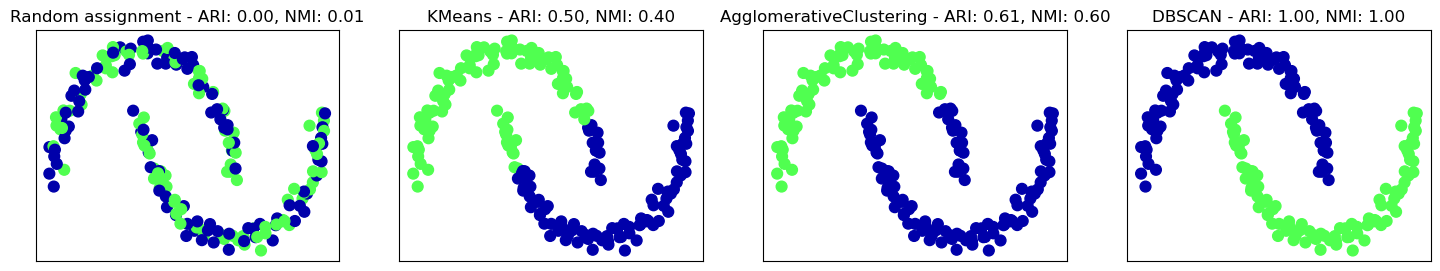

In [8]:
from sklearn.datasets import make_moons
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import normalized_mutual_info_score

X,y = make_moons(n_samples=200, noise=0.05, random_state=0)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(18, 3), subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}, NMI: {:.2f}".format(
    adjusted_rand_score(y, random_clusters), normalized_mutual_info_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}, NMI: {:.2f}".format(
        algorithm.__class__.__name__, adjusted_rand_score(y, clusters), normalized_mutual_info_score(y, clusters)))


### Limitations of ground truth evaluation

- When applying clustering algorithms, we often do not have access to the ground truth.
- If we knew the right clustering, we could just use that information to build a supervised model.
- ARI and NMI usually only helps in developing algorithms, not in assessing their performance.

## Evaluating without ground truth

**Silhouette Score**:
- The silhouette score measures how similar an object is to its own cluster compared to other clusters.
- The silhouette score is calculated using the mean intra-cluster distance ($a$) and the mean nearest-cluster distance ($b$) for each sample.
$$
s = \frac{b - a}{max(a, b)}
$$
where:
- $a$: mean distance between a sample and all other points in the same cluster.
- $b$: mean distance between a sample and all other points in the next nearest cluster.
- $s$: silhouette score
range of silhouette score: [-1, 1]
- s = 1: perfect clustering
- s = 0: overlapping clusters
- s = -1: bad clustering

The silhouette score computes the compactness of a cluster, which doesn't allow for complex cluster shapes.

/Users/chiyeong/anaconda3/envs/study-machine-learning/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


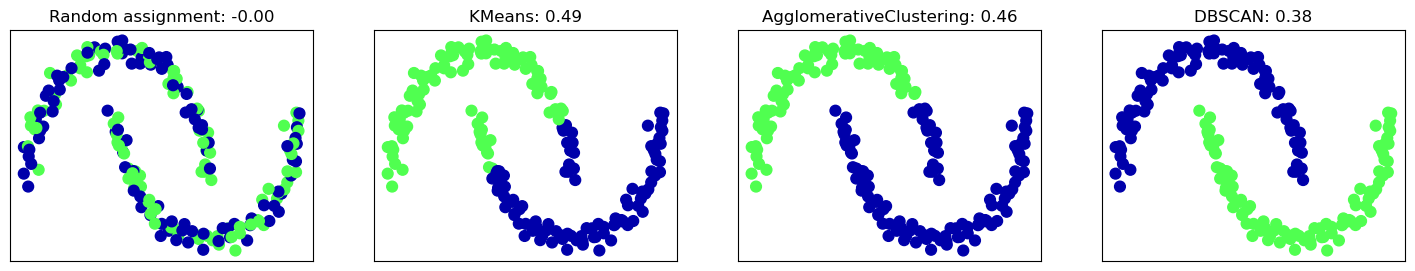

In [9]:
from sklearn.metrics.cluster import silhouette_score

X,y = make_moons(n_samples=200, noise=0.05, random_state=0)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(18, 3), subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{}: {:.2f}".format(
        algorithm.__class__.__name__, silhouette_score(X_scaled, clusters)))

## Comparing clustering algorithms on the faces dataset

In [23]:
# extract eigenfaces from lfw data and transfrom data
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

pca = PCA(n_components=100, whiten=True, random_state=0)
X_pca = pca.fit_transform(X_people)

### Analyzing with DBSCAN

In [24]:
# apply DBSCAN with default parameters
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


- DBSCAN labeled all the data points as noise.

We should tune the hyperparameters to get better results.

In [25]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1  0]


In [26]:
# Count number of points in all clusters and noise.
# bincount doesn't allow negative numbers, so we need to add 1.
# The first number in the result corresponds to noise points.
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))

Number of points per cluster: [  37 2026]


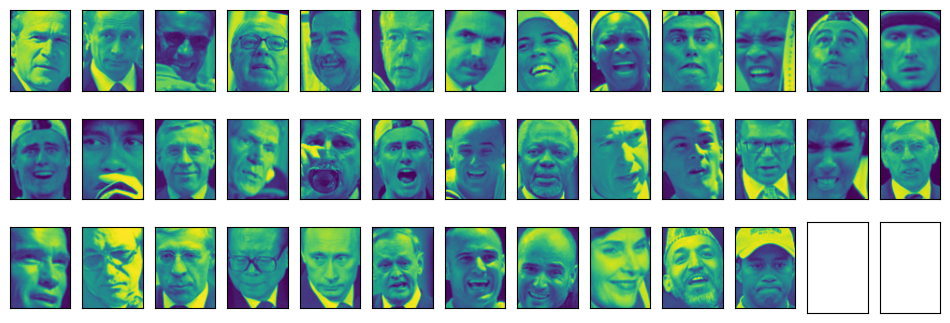

In [27]:
noise = X_people[labels==-1]

fig, axes = plt.subplots(3, 13, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(12, 4))

for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

Why these images are labeled as noise:
- drinking from a glass, wearing glasses, and wearing a hat are not common features in the dataset.

**Outlier detection**:
- Trying to find "the odd one out" in the dataset.
- It can be helpful in preparing the data for supervised learning.
- It can also be used to detect anomalies in the data.

In [28]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps)
    labels = dbscan.fit_predict(X_pca)
    print("Unique labels: {}".format(np.unique(labels)))
    print("Number of points per cluster: {}".format(np.bincount(labels + 1)))


eps=1
Unique labels: [-1]
Number of points per cluster: [2063]

eps=3
Unique labels: [-1]
Number of points per cluster: [2063]

eps=5
Unique labels: [-1]
Number of points per cluster: [2063]

eps=7
Unique labels: [-1  0  1]
Number of points per cluster: [1994   58   11]

eps=9
Unique labels: [-1  0  1]
Number of points per cluster: [1215  844    4]

eps=11
Unique labels: [-1  0]
Number of points per cluster: [ 409 1654]

eps=13
Unique labels: [-1  0]
Number of points per cluster: [ 120 1943]


- There is one large cluster containing most of the points, and some smaller clusters.

This indicates that all images are more or less equally similar to each other.

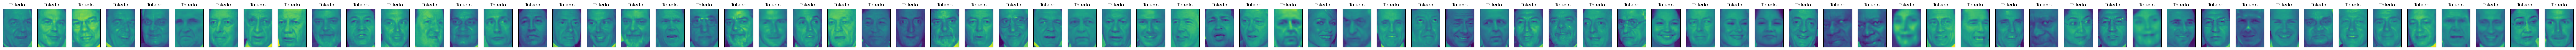

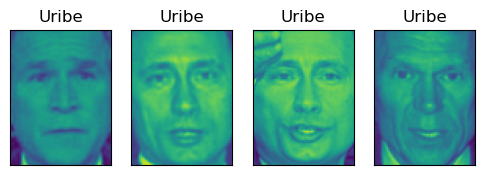

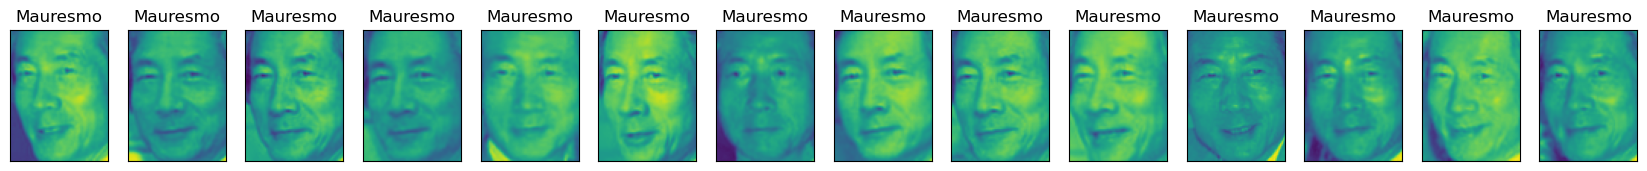

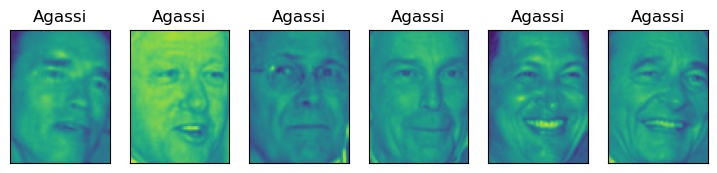

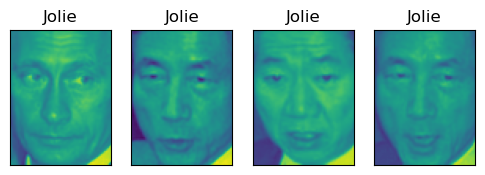

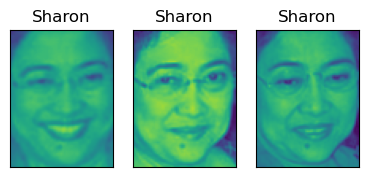

In [29]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for image, label, ax in zip(X_people[mask], labels[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

- Within each cluster, the orientation of the face and the facial expression are similar.

### Analyzing with k-means

In [30]:
# extract clusters with k-means
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

/Users/chiyeong/anaconda3/envs/study-machine-learning/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster sizes k-means: [ 65 184 114  97 237 393 214 376 197 186]


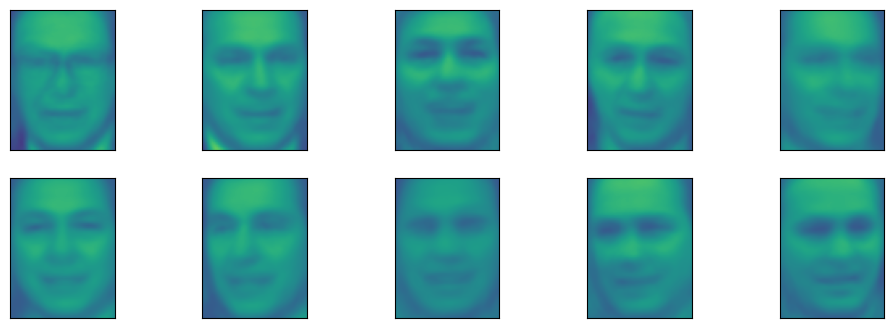

In [31]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape), vmin=0, vmax=1)

The images of cluster centers produced by k-means. (using `pca.inverse_transform` to transform the cluster centers back to the original space)

- The images are very smooth versions of faces.

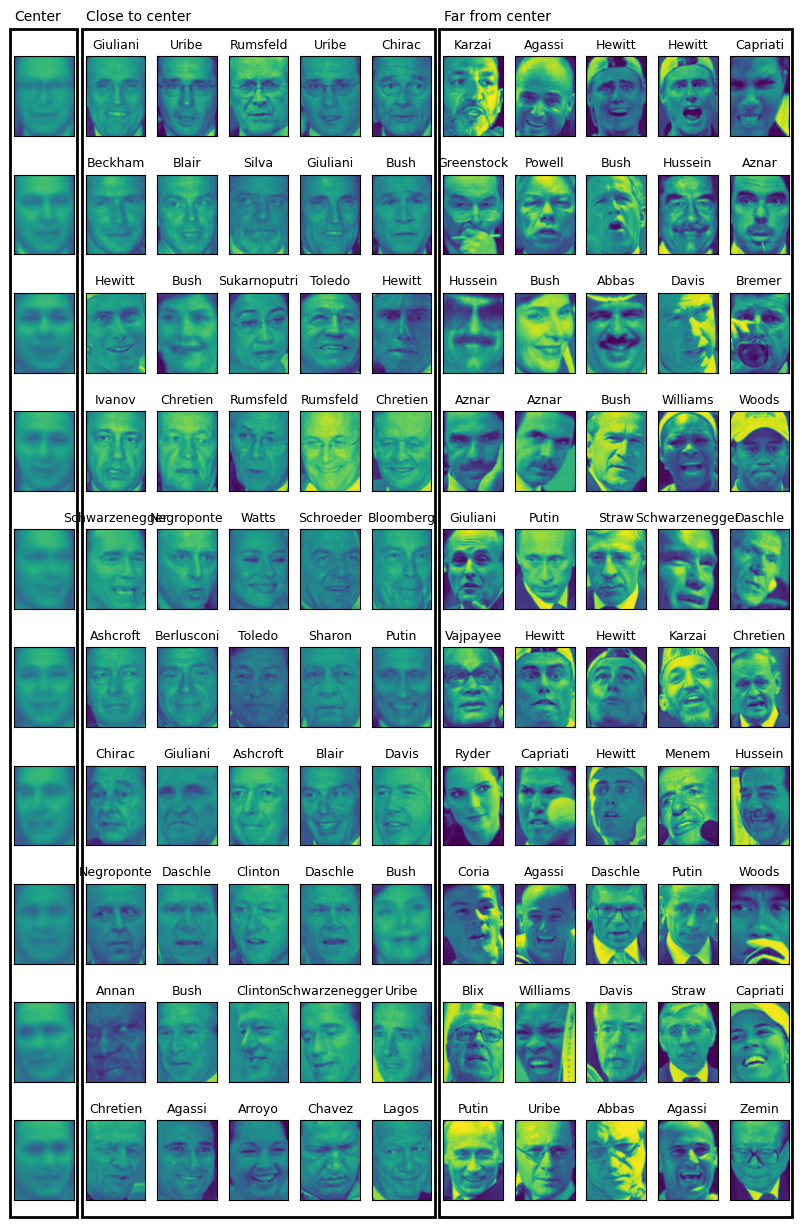

In [32]:
mglearn.plots.plot_kmeans_faces(
    km, pca, X_pca, X_people, y_people, people.target_names)

- The images close to center are quite similar to the cluster centers.

### Analyzing with Agglomerative Clustering

In [33]:
# extract clusters with agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)
print("Cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

Cluster sizes agglomerative clustering: [ 56 101  94 140 154 596 269 178  61 414]


In [34]:
print("ARI: {:.2f}".format(adjusted_rand_score(labels_agg, labels_km)))

ARI: 0.08


- The clusters of Agg and k-means are very different.

Text(0, 0.5, 'Cluster distance')

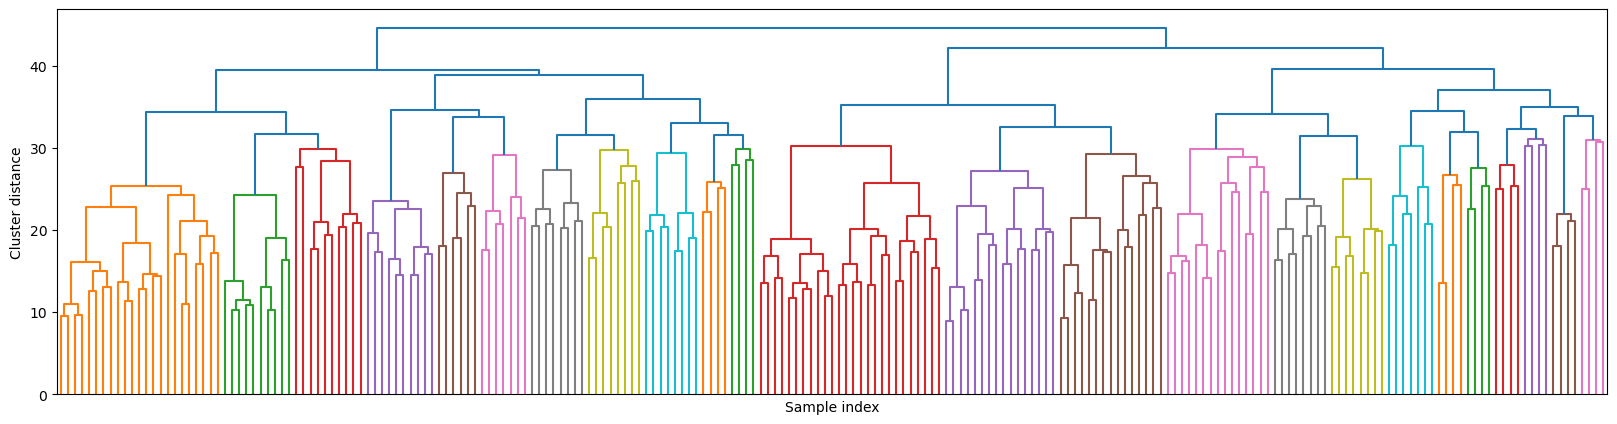

In [35]:
from scipy.cluster.hierarchy import dendrogram, ward

linkage_array = ward(X_pca)
# now we plot the dendrogram for the linkage_array containing the distances
# containing the distances between clusters
plt.figure(figsize=(20, 5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

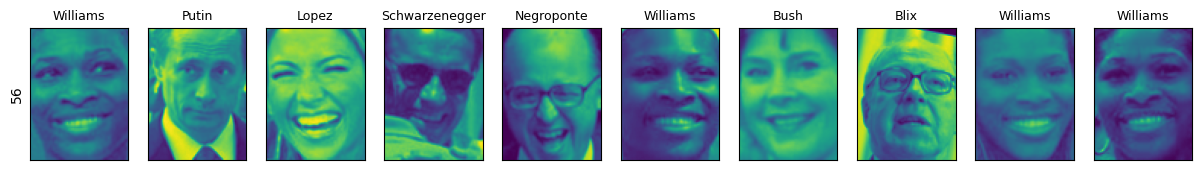

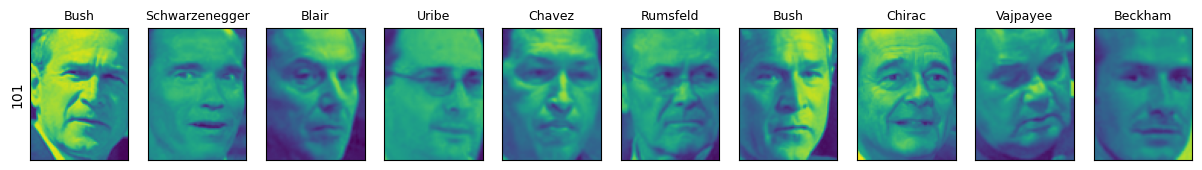

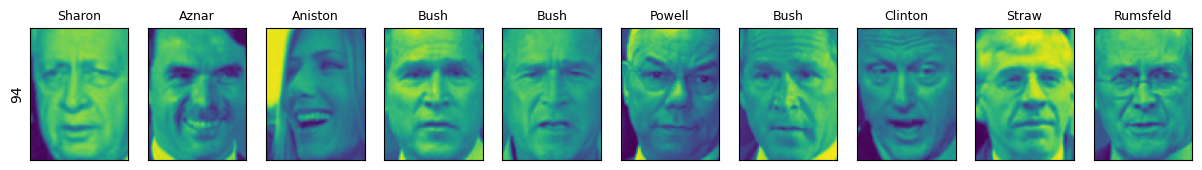

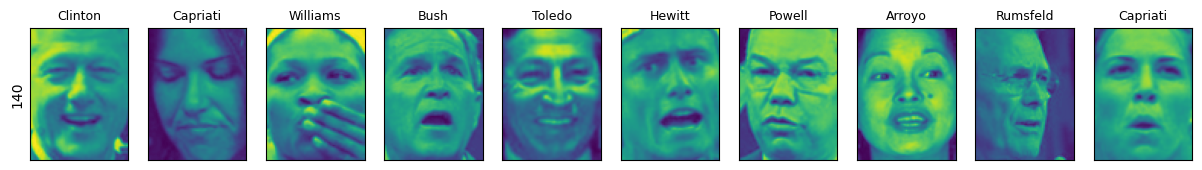

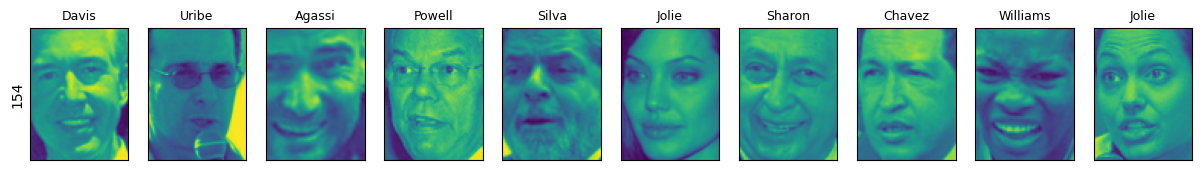

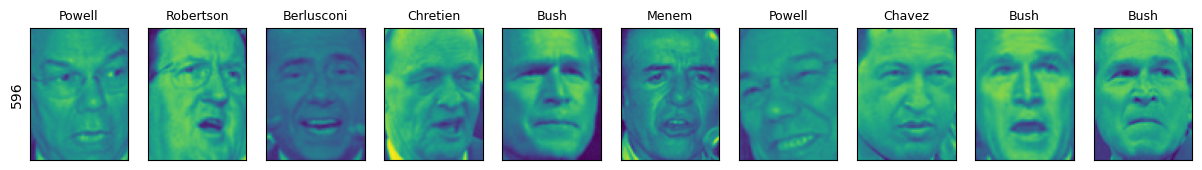

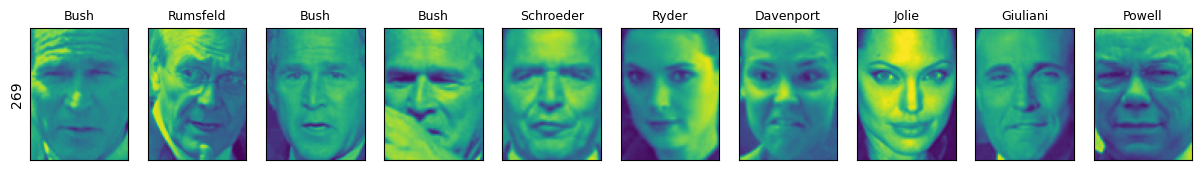

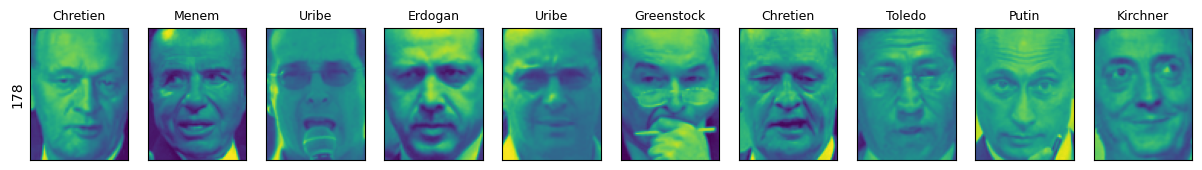

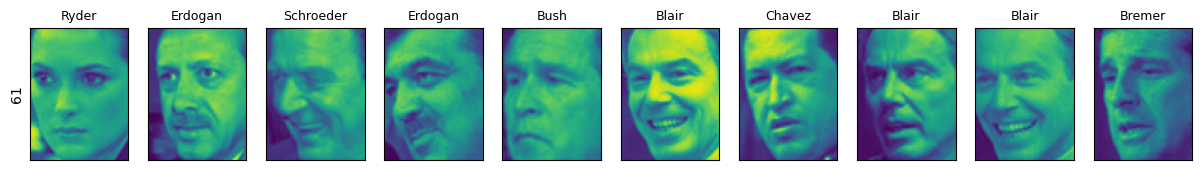

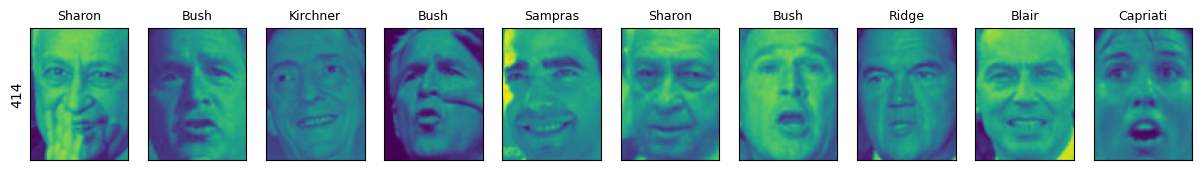

In [36]:
n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9})

Cluster sizes agglomerative clustering: [268 151  44 129  23  63  19 101 116  13  66 102  51  40  30   2  74  44
  25  29  11  19 135  15  20  19  44  84  50  21  31   6   8   8  38  48
  19  66  27   4]


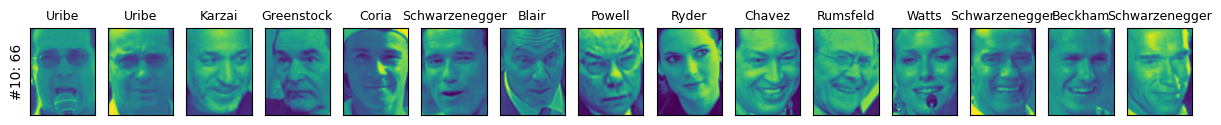

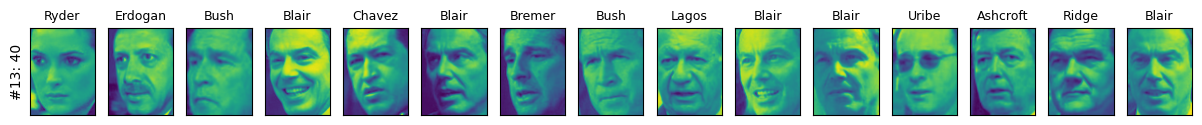

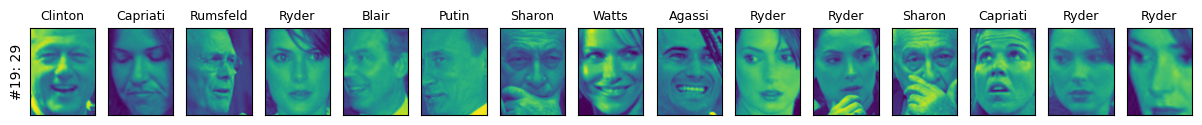

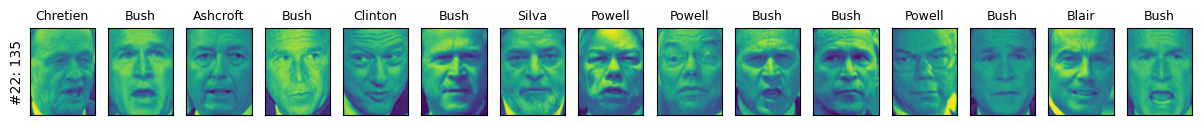

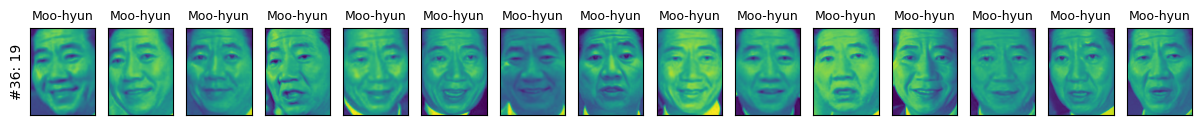

In [38]:
# extract clusters with ward agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=40)
labels_agg = agglomerative.fit_predict(X_pca)
print("Cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

n_clusters = 40
for cluster in [10, 13, 19, 22, 36]:
    mask = labels_agg == cluster
    fig, axes = plt.subplots(
        1, 15, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split(
        )[-1], fontdict={'fontsize': 9})

    for i in range(cluster_size, 15):
        axes[i].set_visible(False)